# How to wait for user input

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](/langgraphjs/concepts/agentic_concepts/#human-in-the-loop). Waiting for human input is a common HIL interaction pattern, allowing the agent to ask the user clarifying questions and await input before proceeding. 

We can implement this in LangGraph using a [breakpoint](/langgraphjs/how-tos/human_in_the_loop/breakpoints/): breakpoints allow us to stop graph execution at a specific step. At this breakpoint, we can wait for human input. Once we have input from the user, we can add it to the graph state and proceed.

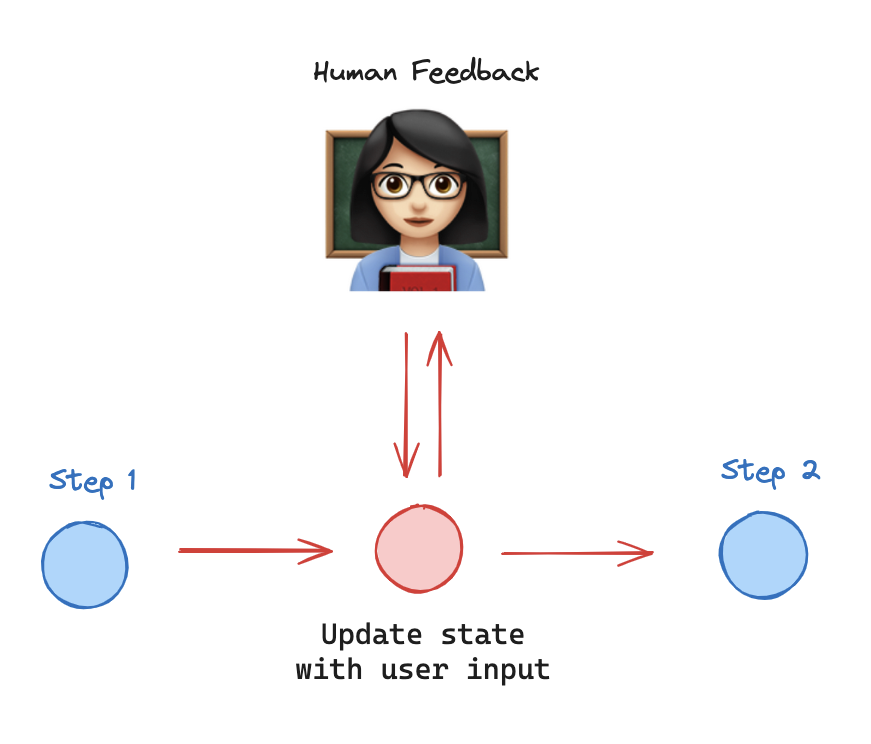

## Setup
First we need to install the packages required

```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core zod
```

Next, we need to set API keys for Anthropic (the LLM we will use)

```bash
export ANTHROPIC_API_KEY=your-api-key
```

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Simple Usage

Let's look at very basic usage of this. One intuitive approach is simply to create a node, `humanFeedback`, that will get user feedback. This allows us to place our feedback gathering at a specific, chosen point in our graph.
 
1) We specify the [breakpoint](/langgraphjs/concepts/low_level/#breakpoints) using `interruptBefore` our `humanFeedback` node.

2) We set up a [checkpointer](/langgraphjs/concepts/low_level/#checkpointer) to save the state of the graph up until this node.

3) We use `.updateState()` to update the state of the graph with the human response we get.

* We [use the `asNode` parameter](/langgraphjs/concepts/low_level/#update-state) to apply this state update as the specified node, `humanFeedback`.
* The graph will then resume execution as if the `humanFeedback` node just acted.

In [1]:
import { StateGraph, Annotation, START, END } from "@langchain/langgraph";
import { MemorySaver } from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  input: Annotation<string>,
  userFeedback: Annotation<string>
});

const step1 = (state: typeof StateAnnotation.State) => {
  console.log("---Step 1---");
  return state;
}

const humanFeedback = (state: typeof StateAnnotation.State) => {
  console.log("--- humanFeedback ---");
  return state;
}

const step3 = (state: typeof StateAnnotation.State) => {
  console.log("---Step 3---");
  return state;
}

const builder = new StateGraph(StateAnnotation)
    .addNode("step1", step1)
    .addNode("humanFeedback", humanFeedback)
    .addNode("step3", step3)
    .addEdge(START, "step1")
    .addEdge("step1", "humanFeedback")
    .addEdge("humanFeedback", "step3")
    .addEdge("step3", END);


// Set up memory
const memory = new MemorySaver()

// Add 
const graph = builder.compile({
  checkpointer: memory,
  interruptBefore: ["humanFeedback"]
});

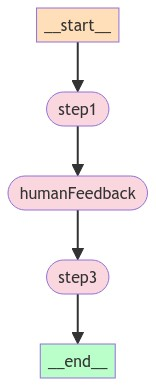

In [2]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

Run until our breakpoint at `step2`

In [3]:
// Input
const initialInput = { input: "hello world" };

// Thread
const config = { configurable: { thread_id: "1" }, streamMode: "values" as const };

// Run the graph until the first interruption
for await (const event of await graph.stream(initialInput, config)) {
  console.log(`--- ${event.input} ---`);
}

// Will log when the graph is interrupted, after step 2.
console.log("--- GRAPH INTERRUPTED ---");

--- hello world ---
---Step 1---
--- hello world ---
--- GRAPH INTERRUPTED ---


Now, we can just manually update our graph state with with the user input - 

In [4]:
// You should replace this with actual user input from a source, e.g stdin
const userInput = "Go to step 3!!";

// We now update the state as if we are the humanFeedback node
await graph.updateState(config, { "userFeedback": userInput, asNode: "humanFeedback" });
    
// We can check the state
console.log("--- State after update ---")
console.log(await graph.getState(config));

// We can check the next node, showing that it is node 3 (which follows human_feedback)
(await graph.getState(config)).next

--- State after update ---
{
  values: { input: 'hello world', userFeedback: 'Go to step 3!!' },
  next: [ 'humanFeedback' ],
  metadata: { source: 'update', step: 2, writes: { step1: [Object] } },
  config: {
    configurable: {
      thread_id: '1',
      checkpoint_id: '1ef5e8fb-89dd-6360-8002-5ff9e3c15c57'
    }
  },
  createdAt: '2024-08-20T01:01:24.246Z',
  parentConfig: undefined
}
[ 'humanFeedback' ]


We can proceed after our breakpoint - 

In [5]:
// Continue the graph execution
for await (const event of await graph.stream(null, config)) {
  console.log(`--- ${event.input} ---`);
}

--- humanFeedback ---
--- hello world ---
---Step 3---
--- hello world ---


We can see our feedback was added to state - 

In [6]:
(await graph.getState(config)).values

{ input: 'hello world', userFeedback: 'Go to step 3!!' }


## Agent

In the context of agents, waiting for user feedback is useful to ask clarifying questions.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We will use OpenAI and / or Anthropic's models and a fake tool (just for demo purposes).

In [1]:
// Set up the tool
import { ChatAnthropic } from "@langchain/anthropic";
import { tool } from "@langchain/core/tools";
import { StateGraph, Annotation, START, END, messagesStateReducer } from "@langchain/langgraph";
import { MemorySaver } from "@langchain/langgraph";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { BaseMessage, AIMessage } from "@langchain/core/messages";
import { z } from "zod";

const GraphMessagesAnnotation = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: messagesStateReducer,
  }),
});

const search = tool((_) => {
  return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈.";
}, {
  name: "search",
  description: "Call to surf the web.",
  schema: z.string(),
})

const tools = [search]
const toolNode = new ToolNode<typeof GraphMessagesAnnotation.State>(tools)

// Set up the model
const model = new ChatAnthropic({ model: "claude-3-5-sonnet-20240620" })

const askHumanTool = tool((_) => {
  return "The human said XYZ";
}, {
  name: "askHuman",
  description: "Ask the human for input.",
  schema: z.string(),
});


const modelWithTools = model.bindTools([...tools, askHumanTool])

// Define nodes and conditional edges

// Define the function that determines whether to continue or not
function shouldContinue(state: typeof GraphMessagesAnnotation.State): "action" | "askHuman" | typeof END {
  const lastMessage = state.messages[state.messages.length - 1];
  const castLastMessage = lastMessage as AIMessage;
  // If there is no function call, then we finish
  if (castLastMessage && !castLastMessage.tool_calls?.length) {
    return END;
  }
  // If tool call is askHuman, we return that node
  // You could also add logic here to let some system know that there's something that requires Human input
  // For example, send a slack message, etc
  if (castLastMessage.tool_calls?.[0]?.name === "askHuman") {
    console.log("--- ASKING HUMAN ---")
    return "askHuman";
  }
  // Otherwise if it isn't, we continue with the action node
  return "action";
}


// Define the function that calls the model
async function callModel(state: typeof GraphMessagesAnnotation.State): Promise<Partial<typeof GraphMessagesAnnotation.State>> {
  const messages = state.messages;
  const response = await modelWithTools.invoke(messages);
  // We return an object with a messages property, because this will get added to the existing list
  return { messages: [response] };
}


// We define a fake node to ask the human
function askHuman(state: typeof GraphMessagesAnnotation.State): Partial<typeof GraphMessagesAnnotation.State> {
  return state;
}

// Define a new graph
const messagesWorkflow = new StateGraph(GraphMessagesAnnotation)
  // Define the two nodes we will cycle between
  .addNode("agent", callModel)
  .addNode("action", toolNode)
  .addNode("askHuman", askHuman)
  // We now add a conditional edge
  .addConditionalEdges(
    // First, we define the start node. We use `agent`.
    // This means these are the edges taken after the `agent` node is called.
    "agent",
    // Next, we pass in the function that will determine which node is called next.
    shouldContinue
  )
  // We now add a normal edge from `action` to `agent`.
  // This means that after `action` is called, `agent` node is called next.
  .addEdge("action", "agent")
  // After we get back the human response, we go back to the agent
  .addEdge("askHuman", "agent")
  // Set the entrypoint as `agent`
  // This means that this node is the first one called
  .addEdge(START, "agent");


// Setup memory
const messagesMemory = new MemorySaver();

// Finally, we compile it!
// This compiles it into a LangChain Runnable,
// meaning you can use it as you would any other runnable
const messagesApp = messagesWorkflow.compile({
    checkpointer: messagesMemory,
    interruptBefore: ["askHuman"]
});

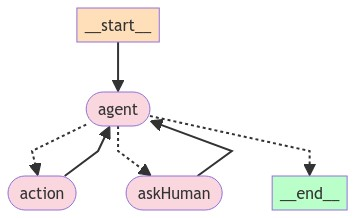

In [2]:
import * as tslab from "tslab";

const drawableGraph2 = messagesApp.getGraph();
const image2 = await drawableGraph2.drawMermaidPng();
const arrayBuffer2 = await image2.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer2));

## Interacting with the Agent

We can now interact with the agent. Let's ask it to ask the user where they are, then tell them the weather. 

This should make it use the `askHuman` tool first, then use the normal tool.

In [3]:
import { HumanMessage } from "@langchain/core/messages";
// Input
const inputs = new HumanMessage("Use the search tool to ask the user where they are, then look up the weather there");

// Thread
const config2 = { configurable: { thread_id: "3" }, streamMode: "values" as const };

for await (const event of await messagesApp.stream({
  messages: [inputs]
}, config2)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}

console.log("next: ", (await messagesApp.getState(config2)).next)

================================ human Message (1) =================================
Use the search tool to ask the user where they are, then look up the weather there
--- ASKING HUMAN ---
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "Certainly! I'll use the askHuman tool to ask the user about their location, and then use the search tool to look up the weather for that location. Let's start by asking the user where they are."
  },
  {
    type: 'tool_use',
    id: 'toolu_01RN181HAAL5BcnMXkexbA1r',
    name: 'askHuman',
    input: {
      input: 'Where are you located? Please provide your city and country.'
    }
  }
]
next:  [ 'askHuman' ]


We now want to update this thread with a response from the user. We then can kick off another run. 

Because we are treating this as a tool call, we will need to update the state as if it is a response from a tool call. In order to do this, we will need to check the state to get the ID of the tool call.

In [4]:
import { ToolMessage } from "@langchain/core/messages";

const currentState = await messagesApp.getState(config2);

const toolCallId = currentState.values.messages[currentState.values.messages.length - 1].tool_calls[0].id;

// We now create the tool call with the id and the response we want
const toolMessage = new ToolMessage({
  tool_call_id: toolCallId,
  content: "san francisco"
});

console.log("next before update state: ", (await messagesApp.getState(config2)).next)

// We now update the state
// Notice that we are also specifying `asNode: "askHuman"`
// This will apply this update as this node,
// which will make it so that afterwards it continues as normal
await messagesApp.updateState(config2, { messages: [toolMessage] }, "askHuman");

// We can check the state
// We can see that the state currently has the `agent` node next
// This is based on how we define our graph,
// where after the `askHuman` node goes (which we just triggered)
// there is an edge to the `agent` node
console.log("next AFTER update state: ", (await messagesApp.getState(config2)).next)
// await messagesApp.getState(config)

next before update state:  [ 'askHuman' ]
next AFTER update state:  [ 'agent' ]


We can now tell the agent to continue. We can just pass in `None` as the input to the graph, since no additional input is needed

In [5]:
for await (const event of await messagesApp.stream(null, config2)) {
  console.log(event)
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  if (recentMsg._getType() === "tool") {
    console.log({
      name: recentMsg.name,
      content: recentMsg.content
    })
  } else if (recentMsg._getType() === "ai") {
    console.log(recentMsg.content)
  }
}

{
  messages: [
    HumanMessage {
      "id": "a80d5763-0f27-4a00-9e54-8a239b499ea1",
      "content": "Use the search tool to ask the user where they are, then look up the weather there",
      "additional_kwargs": {},
      "response_metadata": {}
    },
    AIMessage {
      "id": "msg_01CsrDn46VqNXrdkpVHbcMKA",
      "content": [
        {
          "type": "text",
          "text": "Certainly! I'll use the askHuman tool to ask the user about their location, and then use the search tool to look up the weather for that location. Let's start by asking the user where they are."
        },
        {
          "type": "tool_use",
          "id": "toolu_01RN181HAAL5BcnMXkexbA1r",
          "name": "askHuman",
          "input": {
            "input": "Where are you located? Please provide your city and country."
          }
        }
      ],
      "additional_kwargs": {
        "id": "msg_01CsrDn46VqNXrdkpVHbcMKA",
        "type": "message",
        "role": "assistant",
        "model"